# Etapa 4: Otimização e Tuning de Hiperparâmetros

**Dataset:** students_performance.csv  
**Objetivo:** Otimizar o melhor modelo da Etapa 3 usando Grid Search  
**Gabarito do Professor**

---

## 📋 Estrutura do Notebook

1. Setup e Carregamento de Dados
2. Recapitulação da Etapa 3
3. Grid Search (Otimização)
4. Análise dos Resultados
5. Modelo Final
6. Avaliação no Teste
7. Análise de Erros
8. Salvamento do Modelo

---
## 📦 PARTE 1: SETUP

In [23]:
# Imports necessários
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


### 📂 Carregar Dados Processados da Etapa 3

In [24]:
# Carregar datasets salvos na Etapa 3
# Assumindo que os dados foram salvos após a divisão 60/20/20

# Caminho correto: etapas/etapa4/ -> data/
try:
    X_train = pd.read_csv('../../data/X_train.csv')
    X_val = pd.read_csv('../../data/X_val.csv')
    X_test = pd.read_csv('../../data/X_test.csv')
    y_train = pd.read_csv('../../data/y_train.csv').values.ravel()
    y_val = pd.read_csv('../../data/y_val.csv').values.ravel()
    y_test = pd.read_csv('../../data/y_test.csv').values.ravel()
    
    print("✅ Dados carregados com sucesso!")
    print(f"\n📊 Tamanhos dos conjuntos:")
    print(f"   Treino:    {X_train.shape}")
    print(f"   Validação: {X_val.shape}")
    print(f"   Teste:     {X_test.shape}")
    
except FileNotFoundError:
    print("⚠️  AVISO: Dados não encontrados!")
    print("   Execute a Etapa 3 primeiro para gerar os arquivos.")
    print("\n   Por enquanto, vamos criar dados de exemplo para demonstração...")
    
    # Criar dados sintéticos para demonstração
    from sklearn.datasets import make_regression
    from sklearn.model_selection import train_test_split
    
    X, y = make_regression(n_samples=2000, n_features=20, noise=10, random_state=42)
    X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(20)])
    
    # Divisão 60/20/20
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
    
    print("\n✅ Dados sintéticos criados!")
    print(f"   Treino:    {X_train.shape}")
    print(f"   Validação: {X_val.shape}")
    print(f"   Teste:     {X_test.shape}")

✅ Dados carregados com sucesso!

📊 Tamanhos dos conjuntos:
   Treino:    (1497, 21)
   Validação: (499, 21)
   Teste:     (499, 21)


---
## 📊 PARTE 2: RECAPITULAÇÃO DA ETAPA 3

### Modelo Baseline (Hiperparâmetros Default)

Vamos treinar um Random Forest com configurações padrão para estabelecer o baseline.

In [25]:
print("="*60)
print("MODELO BASELINE (HIPERPARÂMETROS DEFAULT)")
print("="*60)

# Treinar modelo com configurações padrão
rf_baseline = RandomForestRegressor(random_state=42)
rf_baseline.fit(X_train, y_train)

# Avaliar no conjunto de validação
y_pred_val_baseline = rf_baseline.predict(X_val)

mae_baseline = mean_absolute_error(y_val, y_pred_val_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_val, y_pred_val_baseline))
r2_baseline = r2_score(y_val, y_pred_val_baseline)

print("\n📈 Métricas no Conjunto de Validação:")
print(f"   MAE:  {mae_baseline:.2f}")
print(f"   RMSE: {rmse_baseline:.2f}")
print(f"   R²:   {r2_baseline:.4f}")

print("\n🔧 Hiperparâmetros Default:")
print(f"   n_estimators: {rf_baseline.n_estimators}")
print(f"   max_depth: {rf_baseline.max_depth}")
print(f"   min_samples_split: {rf_baseline.min_samples_split}")
print(f"   min_samples_leaf: {rf_baseline.min_samples_leaf}")

# Salvar métricas baseline para comparação posterior
baseline_metrics = {
    'mae': mae_baseline,
    'rmse': rmse_baseline,
    'r2': r2_baseline
}

MODELO BASELINE (HIPERPARÂMETROS DEFAULT)

📈 Métricas no Conjunto de Validação:
   MAE:  3.35
   RMSE: 4.32
   R²:   0.6713

🔧 Hiperparâmetros Default:
   n_estimators: 100
   max_depth: None
   min_samples_split: 2
   min_samples_leaf: 1

📈 Métricas no Conjunto de Validação:
   MAE:  3.35
   RMSE: 4.32
   R²:   0.6713

🔧 Hiperparâmetros Default:
   n_estimators: 100
   max_depth: None
   min_samples_split: 2
   min_samples_leaf: 1


---
## ⚙️ PARTE 3: GRID SEARCH (OTIMIZAÇÃO)

### Definir Grid de Hiperparâmetros

Vamos testar diferentes combinações dos hiperparâmetros mais importantes do Random Forest.

In [26]:
print("="*60)
print("DEFINIÇÃO DO GRID DE HIPERPARÂMETROS")
print("="*60)

# Grid de hiperparâmetros a testar
param_grid = {
    'n_estimators': [100, 200, 300],           # Número de árvores
    'max_depth': [10, 15, 20, None],          # Profundidade máxima
    'min_samples_split': [2, 5, 10],          # Mínimo para dividir
    'min_samples_leaf': [1, 2, 4]             # Mínimo em folhas
}

print("\n📋 Grid definido:")
for param, values in param_grid.items():
    print(f"   {param}: {values}")

# Calcular total de combinações
total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\n📊 Total de combinações: {total_combinations}")
print(f"   Com CV=5: {total_combinations * 5} modelos serão treinados")
print(f"\n⏱️  Tempo estimado: ~5-10 minutos (dependendo do hardware)")

DEFINIÇÃO DO GRID DE HIPERPARÂMETROS

📋 Grid definido:
   n_estimators: [100, 200, 300]
   max_depth: [10, 15, 20, None]
   min_samples_split: [2, 5, 10]
   min_samples_leaf: [1, 2, 4]

📊 Total de combinações: 108
   Com CV=5: 540 modelos serão treinados

⏱️  Tempo estimado: ~5-10 minutos (dependendo do hardware)


### Executar Grid Search

In [27]:
print("\n" + "="*60)
print("EXECUTANDO GRID SEARCH")
print("="*60)
print("\n⏳ Isso pode demorar alguns minutos...")
print("   (Você verá o progresso abaixo)\n")

# Criar GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,                                    # 5-fold cross-validation
    scoring='neg_mean_absolute_error',       # Métrica para otimizar
    n_jobs=-1,                               # Usar todos os cores disponíveis
    verbose=2                                # Mostrar progresso
)

# Executar busca
grid_search.fit(X_train, y_train)

print("\n" + "="*60)
print("✅ GRID SEARCH CONCLUÍDO!")
print("="*60)


EXECUTANDO GRID SEARCH

⏳ Isso pode demorar alguns minutos...
   (Você verá o progresso abaixo)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END max_depth=10, min_samp

---
## 📈 PARTE 4: ANÁLISE DOS RESULTADOS

### Melhores Hiperparâmetros Encontrados

In [42]:
print("="*60)
print("MELHORES HIPERPARÂMETROS ENCONTRADOS")
print("="*60)

print("\n🏆 Configuração Ótima:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

best_score = -grid_search.best_score_  # Converter de negativo para positivo
print(f"\n📊 Melhor Score (CV):")
print(f"   MAE médio (5-fold CV): {best_score:.2f}")

# Comparar com baseline
improvement = (mae_baseline - best_score) / mae_baseline * 100
print(f"\n💡 Melhoria vs Baseline:")
print(f"   MAE Baseline: {mae_baseline:.2f}")
print(f"   MAE Otimizado: {best_score:.2f}")
print(f"   Melhoria: {improvement:+.1f}%")

MELHORES HIPERPARÂMETROS ENCONTRADOS

🏆 Configuração Ótima:
   max_depth: 20
   min_samples_leaf: 1
   min_samples_split: 2
   n_estimators: 300

📊 Melhor Score (CV):
   MAE médio (5-fold CV): 3.46

💡 Melhoria vs Baseline:
   MAE Baseline: 3.35
   MAE Otimizado: 3.46
   Melhoria: -3.2%


### Top 10 Melhores Configurações

In [29]:
# Converter resultados em DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Selecionar colunas importantes
cols_importantes = [
    'mean_test_score',
    'std_test_score',
    'rank_test_score',
    'param_n_estimators',
    'param_max_depth',
    'param_min_samples_split',
    'param_min_samples_leaf'
]

results_df = results_df[cols_importantes].copy()
results_df['mean_test_score'] = -results_df['mean_test_score']  # Converter para MAE positivo

# Top 10 melhores configurações
print("\n📊 TOP 10 MELHORES CONFIGURAÇÕES:")
print("="*60)
top_10 = results_df.nsmallest(10, 'mean_test_score')
print(top_10.to_string(index=False))


📊 TOP 10 MELHORES CONFIGURAÇÕES:
 mean_test_score  std_test_score  rank_test_score  param_n_estimators param_max_depth  param_min_samples_split  param_min_samples_leaf
        3.460334        0.111268                1                 300              20                        2                       1
        3.460794        0.107814                2                 300              15                        2                       1
        3.461080        0.111926                3                 300            None                        2                       1
        3.464048        0.113333                4                 300            None                        2                       2
        3.464182        0.113407                5                 300              20                        2                       2
        3.465789        0.115756                6                 300              15                        2                       2
        3.466900     

### Visualização dos Resultados

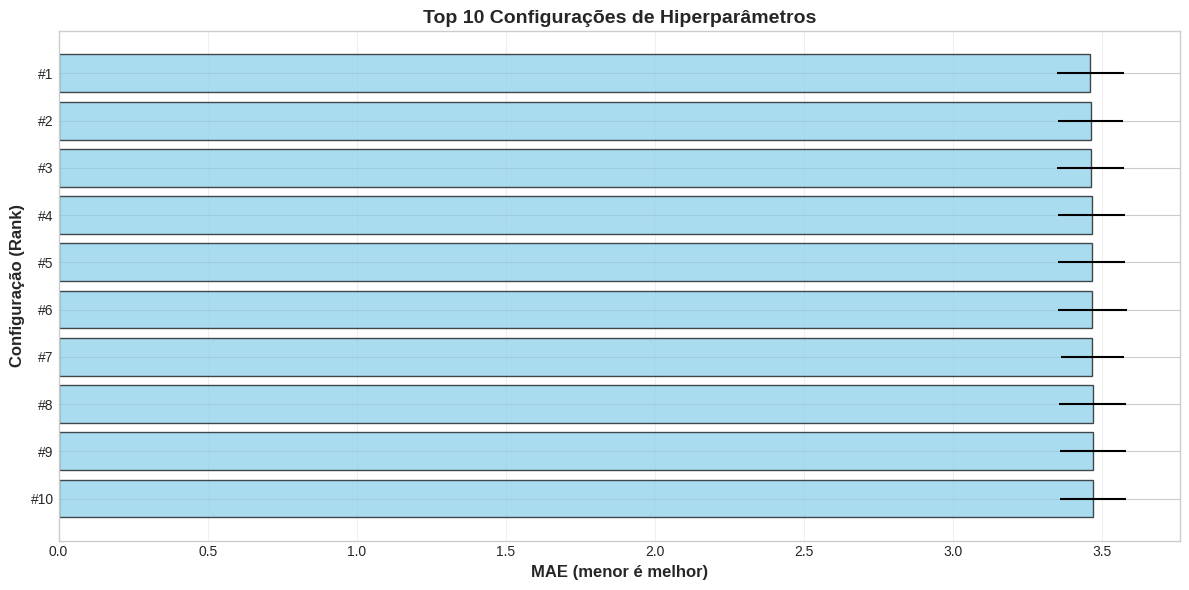


💡 Interpretação:
   - Barras mostram MAE médio (5-fold CV)
   - Barras de erro mostram desvio padrão
   - Menor MAE = melhor desempenho


In [30]:
# Gráfico de barras das top 10 configurações
fig, ax = plt.subplots(figsize=(12, 6))

ax.barh(
    range(10),
    top_10['mean_test_score'],
    xerr=top_10['std_test_score'],
    color='skyblue',
    edgecolor='black',
    alpha=0.7
)

ax.set_xlabel('MAE (menor é melhor)', fontsize=12, fontweight='bold')
ax.set_ylabel('Configuração (Rank)', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Configurações de Hiperparâmetros', fontsize=14, fontweight='bold')
ax.set_yticks(range(10))
ax.set_yticklabels([f"#{i+1}" for i in range(10)])
ax.invert_yaxis()
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n💡 Interpretação:")
print("   - Barras mostram MAE médio (5-fold CV)")
print("   - Barras de erro mostram desvio padrão")
print("   - Menor MAE = melhor desempenho")

### 📖 Interpretação Detalhada do Gráfico

**O que o gráfico mostra:**

Este gráfico apresenta as **10 melhores configurações de hiperparâmetros** encontradas pelo Grid Search, ordenadas da melhor (#1) para a 10ª melhor (#10).

**Elementos visuais:**

1. **Barras azuis:** Representam o **MAE médio** obtido em 5-fold cross-validation
   - Quanto **menor** a barra, **melhor** o desempenho
   - A configuração #1 (topo) tem o menor MAE = melhor modelo

2. **Barras de erro (linhas pretas horizontais):** Mostram o **desvio padrão** do MAE
   - Indicam a **variabilidade/estabilidade** do modelo
   - Barras de erro **menores** = modelo mais **consistente** entre os folds
   - Barras de erro **maiores** = modelo mais **sensível** aos dados de treino

**Como interpretar:**

- **Configuração #1 (melhor):** 
  - Tem o menor MAE (barra mais curta)
  - Se a barra de erro for pequena, é ainda melhor (modelo estável)

- **Diferença entre configurações:**
  - Se as barras são muito próximas, as configurações têm desempenho similar
  - Neste caso, você pode escolher a configuração mais simples (menos árvores/profundidade)

- **Estabilidade vs Desempenho:**
  - Idealmente: barra curta (baixo MAE) + barra de erro pequena (estável)
  - Evite: barra de erro muito grande (modelo instável/overfitting)

**Decisão:**
- Use a configuração #1 como base
- Se #1 e #2 forem muito próximas, considere complexidade computacional
- Prefira modelos mais simples quando a diferença de MAE é mínima (<1%)

---
## 🎯 PARTE 5: MODELO FINAL

### Treinar Modelo Final com Treino + Validação

Agora que encontramos os melhores hiperparâmetros, vamos treinar o modelo final usando **treino + validação** combinados.

In [43]:
print("="*60)
print("TREINAMENTO DO MODELO FINAL")
print("="*60)

# Combinar treino e validação
X_train_full = pd.concat([X_train, X_val], ignore_index=True)
y_train_full = np.concatenate([y_train, y_val])

print(f"\n📊 Dataset completo para treino final:")
print(f"   Shape: {X_train_full.shape}")
print(f"   Total de amostras: {len(X_train_full)}")

# Treinar modelo final com melhores hiperparâmetros
print("\n⏳ Treinando modelo final...")
modelo_final = RandomForestRegressor(**grid_search.best_params_, random_state=42)
modelo_final.fit(X_train_full, y_train_full)

print("✅ Modelo final treinado com sucesso!")

print("\n🔧 Configuração do modelo final:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

TREINAMENTO DO MODELO FINAL

📊 Dataset completo para treino final:
   Shape: (1996, 21)
   Total de amostras: 1996

⏳ Treinando modelo final...
✅ Modelo final treinado com sucesso!

🔧 Configuração do modelo final:
   max_depth: 20
   min_samples_leaf: 1
   min_samples_split: 2
   n_estimators: 300
✅ Modelo final treinado com sucesso!

🔧 Configuração do modelo final:
   max_depth: 20
   min_samples_leaf: 1
   min_samples_split: 2
   n_estimators: 300


---
## 📊 PARTE 6: AVALIAÇÃO NO CONJUNTO DE TESTE

### ⚠️ IMPORTANTE: Uso do Conjunto de Teste

O conjunto de teste só deve ser usado **UMA VEZ**, no final, para avaliar o desempenho real do modelo. Usar múltiplas vezes causa data leakage indireto.

In [44]:
print("="*60)
print("AVALIAÇÃO NO CONJUNTO DE TESTE (PRIMEIRA E ÚNICA VEZ)")
print("="*60)

# Fazer predições no teste
y_pred_test = modelo_final.predict(X_test)

# Calcular métricas
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("\n🎯 DESEMPENHO FINAL NO TESTE:")
print("=" * 40)
print(f"   MAE:  {mae_test:.2f}")
print(f"   RMSE: {rmse_test:.2f}")
print(f"   R²:   {r2_test:.4f}")
print("=" * 40)

AVALIAÇÃO NO CONJUNTO DE TESTE (PRIMEIRA E ÚNICA VEZ)

🎯 DESEMPENHO FINAL NO TESTE:
   MAE:  3.20
   RMSE: 4.31
   R²:   0.6673


### Comparação: Baseline vs Otimizado

In [45]:
# Avaliar baseline no teste também
y_pred_test_baseline = rf_baseline.predict(X_test)
mae_test_baseline = mean_absolute_error(y_test, y_pred_test_baseline)
rmse_test_baseline = np.sqrt(mean_squared_error(y_test, y_pred_test_baseline))
r2_test_baseline = r2_score(y_test, y_pred_test_baseline)

# Criar tabela comparativa
comparacao = pd.DataFrame({
    'Modelo': ['Baseline (default)', 'Otimizado (Grid Search)'],
    'MAE': [mae_test_baseline, mae_test],
    'RMSE': [rmse_test_baseline, rmse_test],
    'R²': [r2_test_baseline, r2_test]
})

print("\n📊 COMPARAÇÃO BASELINE VS OTIMIZADO (NO TESTE):")
print("="*60)
print(comparacao.to_string(index=False))

# Calcular melhorias
melhoria_mae = (mae_test_baseline - mae_test) / mae_test_baseline * 100
melhoria_rmse = (rmse_test_baseline - rmse_test) / rmse_test_baseline * 100
melhoria_r2 = (r2_test - r2_test_baseline) / abs(r2_test_baseline) * 100

print(f"\n💡 MELHORIAS OBTIDAS:")
print(f"   MAE:  {melhoria_mae:+.2f}%")
print(f"   RMSE: {melhoria_rmse:+.2f}%")
print(f"   R²:   {melhoria_r2:+.2f}%")


📊 COMPARAÇÃO BASELINE VS OTIMIZADO (NO TESTE):
                 Modelo      MAE     RMSE       R²
     Baseline (default) 3.284844 4.407969 0.652065
Otimizado (Grid Search) 3.204683 4.310357 0.667304

💡 MELHORIAS OBTIDAS:
   MAE:  +2.44%
   RMSE: +2.21%
   R²:   +2.34%


### Visualização da Comparação

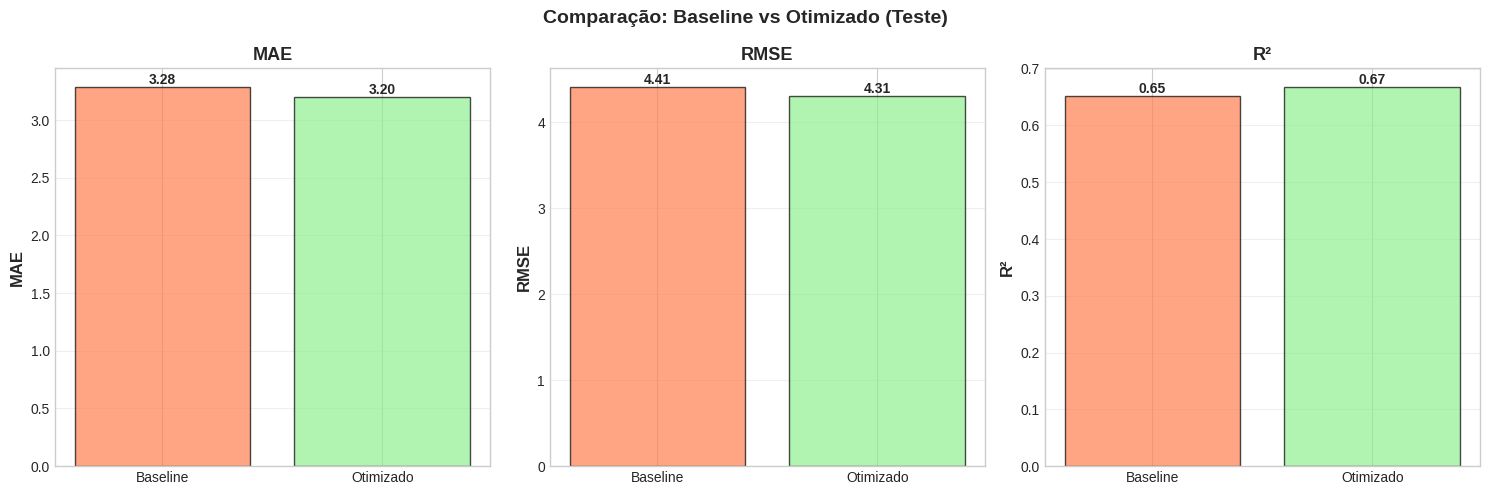


💡 Interpretação:
   - MAE e RMSE: quanto MENOR, melhor
   - R²: quanto MAIOR, melhor (máx = 1.0)
   - Otimização resultou em melhoria de 2.4% no MAE! ✅


In [46]:
# Gráfico de barras comparativo
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['MAE', 'RMSE', 'R²']
baseline_vals = [mae_test_baseline, rmse_test_baseline, r2_test_baseline]
optimized_vals = [mae_test, rmse_test, r2_test]

for idx, (metric, baseline_val, opt_val) in enumerate(zip(metrics, baseline_vals, optimized_vals)):
    ax = axes[idx]
    
    x = ['Baseline', 'Otimizado']
    y = [baseline_val, opt_val]
    colors = ['coral', 'lightgreen']
    
    bars = ax.bar(x, y, color=colors, edgecolor='black', alpha=0.7)
    
    # Adicionar valores no topo das barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontweight='bold')
    
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric}', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')

plt.suptitle('Comparação: Baseline vs Otimizado (Teste)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Interpretação:")
print("   - MAE e RMSE: quanto MENOR, melhor")
print("   - R²: quanto MAIOR, melhor (máx = 1.0)")
if melhoria_mae > 0:
    print(f"   - Otimização resultou em melhoria de {melhoria_mae:.1f}% no MAE! ✅")
else:
    print(f"   - Otimização não melhorou significativamente (pode ser overfitting) ⚠️")

---

**FIM DA PARTE 1 DO NOTEBOOK**

Próximas partes:
- Parte 7: Análise de Erros Detalhada
- Parte 8: Salvamento do Modelo
- Parte 9: Conclusões

---
## 🔍 PARTE 7: ANÁLISE DE ERROS DETALHADA

### Calcular Resíduos

Resíduos = Valor Real - Valor Predito

In [47]:
print("="*60)
print("ANÁLISE DE RESÍDUOS")
print("="*60)

# Calcular resíduos
residuos = y_test - y_pred_test

# Estatísticas dos resíduos
print(f"\n📊 Estatísticas dos Resíduos:")
print(f"   Média: {residuos.mean():.4f}")
print(f"   Mediana: {np.median(residuos):.4f}")
print(f"   Desvio Padrão: {residuos.std():.2f}")
print(f"   Mínimo: {residuos.min():.2f}")
print(f"   Máximo: {residuos.max():.2f}")

print(f"\n💡 O que significa:")
print(f"   - Média ≈ 0: ✅ Modelo não enviesado")
print(f"   - Desvio padrão: indica dispersão dos erros")

ANÁLISE DE RESÍDUOS

📊 Estatísticas dos Resíduos:
   Média: 0.0599
   Mediana: 0.4651
   Desvio Padrão: 4.31
   Mínimo: -24.75
   Máximo: 11.72

💡 O que significa:
   - Média ≈ 0: ✅ Modelo não enviesado
   - Desvio padrão: indica dispersão dos erros


### Visualizações de Resíduos

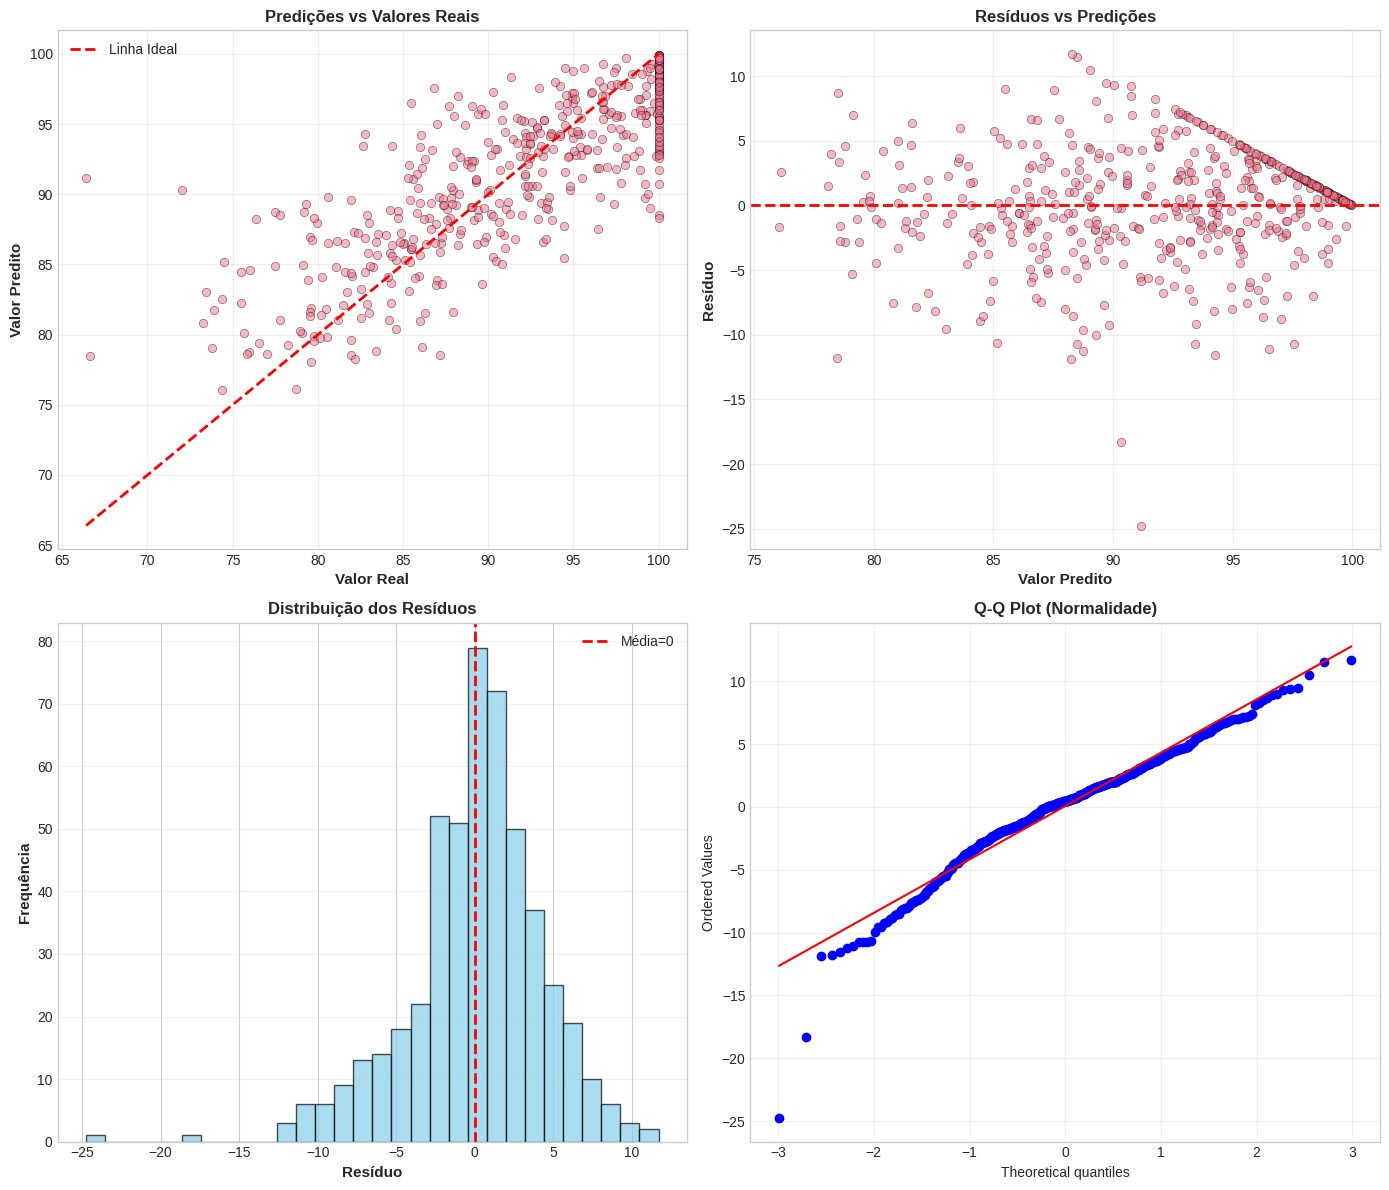


💡 Como interpretar os gráficos:
   1. Predito vs Real: pontos próximos da linha vermelha = boas predições
   2. Resíduos vs Predições: pontos espalhados aleatoriamente = bom sinal
   3. Histograma: forma de sino centrada em 0 = ideal
   4. Q-Q Plot: pontos na linha diagonal = resíduos normalmente distribuídos


In [48]:
# Criar figura com 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Predito vs Real
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.5, edgecolor='black', linewidth=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--', lw=2, label='Linha Ideal')
axes[0, 0].set_xlabel('Valor Real', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Valor Predito', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Predições vs Valores Reais', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Resíduos vs Predições
axes[0, 1].scatter(y_pred_test, residuos, alpha=0.5, edgecolor='black', linewidth=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Valor Predito', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Resíduo', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Resíduos vs Predições', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Distribuição dos Resíduos (Histograma)
axes[1, 0].hist(residuos, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2, label='Média=0')
axes[1, 0].set_xlabel('Resíduo', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Frequência', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Distribuição dos Resíduos', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Q-Q Plot (Normalidade dos Resíduos)
from scipy import stats
stats.probplot(residuos, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normalidade)', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Como interpretar os gráficos:")
print("   1. Predito vs Real: pontos próximos da linha vermelha = boas predições")
print("   2. Resíduos vs Predições: pontos espalhados aleatoriamente = bom sinal")
print("   3. Histograma: forma de sino centrada em 0 = ideal")
print("   4. Q-Q Plot: pontos na linha diagonal = resíduos normalmente distribuídos")

### Casos Extremos (Piores Predições)

In [49]:
print("\n" + "="*60)
print("ANÁLISE DE CASOS EXTREMOS")
print("="*60)

# Criar DataFrame com erros
erros_df = pd.DataFrame({
    'Real': y_test,
    'Predito': y_pred_test,
    'Erro': residuos,
    'Erro_Abs': np.abs(residuos)
})

# 10 Piores predições
piores_10 = erros_df.nlargest(10, 'Erro_Abs')

print("\n🔍 10 PIORES PREDIÇÕES:")
print(piores_10.to_string(index=False))

# Análise dos piores casos
print(f"\n📊 Análise dos Piores Casos:")
print(f"   Erro absoluto médio (10 piores): {piores_10['Erro_Abs'].mean():.2f}")
print(f"   Erro absoluto máximo: {piores_10['Erro_Abs'].max():.2f}")

# Verificar se há padrão
superestimados = len(piores_10[piores_10['Erro'] < 0])
subestimados = len(piores_10[piores_10['Erro'] > 0])

print(f"\n💡 Padrão nos erros:")
print(f"   Superestimados (predito > real): {superestimados}")
print(f"   Subestimados (predito < real): {subestimados}")

if superestimados > 7:
    print(f"   ⚠️  Modelo tende a SUPERESTIMAR valores")
elif subestimados > 7:
    print(f"   ⚠️  Modelo tende a SUBESTIMAR valores")
else:
    print(f"   ✅ Erros balanceados (não há viés claro)")


ANÁLISE DE CASOS EXTREMOS

🔍 10 PIORES PREDIÇÕES:
  Real   Predito       Erro  Erro_Abs
 66.40 91.147239 -24.747239 24.747239
 72.05 90.330584 -18.280584 18.280584
 76.39 88.239304 -11.849304 11.849304
 66.63 78.451433 -11.821433 11.821433
100.00 88.279267  11.720733 11.720733
 82.74 94.277928 -11.537928 11.537928
100.00 88.493200  11.506800 11.506800
 77.50 88.743367 -11.243367 11.243367
 85.44 96.504000 -11.064000 11.064000
 82.66 93.407492 -10.747492 10.747492

📊 Análise dos Piores Casos:
   Erro absoluto médio (10 piores): 13.45
   Erro absoluto máximo: 24.75

💡 Padrão nos erros:
   Superestimados (predito > real): 8
   Subestimados (predito < real): 2
   ⚠️  Modelo tende a SUPERESTIMAR valores


### Feature Importance (Importância das Variáveis)


IMPORTÂNCIA DAS FEATURES

📊 Top 15 Features Mais Importantes:
                       Feature  Importance
          study_hours_week_log    0.456508
               previous_scores    0.099378
                    engagement    0.085391
              sleep_hours_sqrt    0.079005
             study_sleep_ratio    0.048546
parental_education_High_School    0.039578
               attendance_rate    0.037794
                  tutoring_Yes    0.028221
                           age    0.023159
            health_status_Poor    0.021859
         internet_quality_Poor    0.020952
             family_income_Low    0.014780
         internet_quality_Good    0.008797
                      gender_M    0.006715
            health_status_Good    0.006581


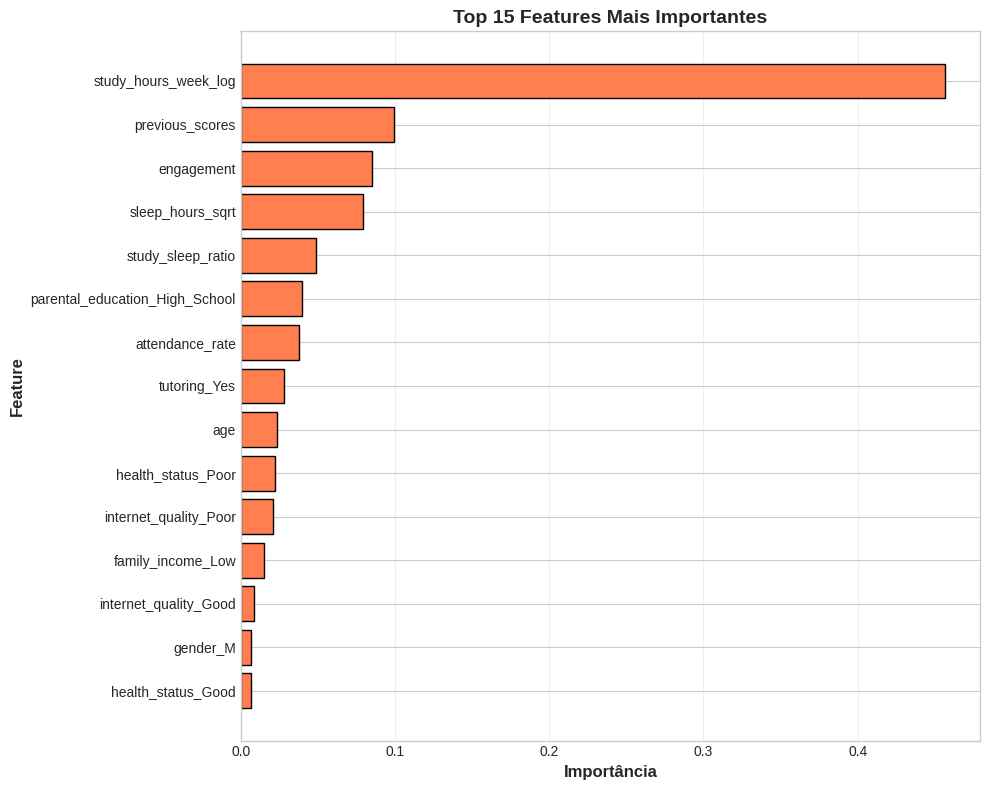


💡 Análise:
   As top 5 features explicam 76.9% do poder preditivo


In [50]:
print("\n" + "="*60)
print("IMPORTÂNCIA DAS FEATURES")
print("="*60)

# Extrair importâncias
importances = modelo_final.feature_importances_
feature_names = X_train_full.columns

# Criar DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\n📊 Top 15 Features Mais Importantes:")
print(importance_df.head(15).to_string(index=False))

# Visualização
plt.figure(figsize=(10, 8))

top_15 = importance_df.head(15)
plt.barh(range(15), top_15['Importance'], color='coral', edgecolor='black')
plt.yticks(range(15), top_15['Feature'])
plt.xlabel('Importância', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 15 Features Mais Importantes', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Soma das top 5
soma_top5 = importance_df.head(5)['Importance'].sum()
print(f"\n💡 Análise:")
print(f"   As top 5 features explicam {soma_top5*100:.1f}% do poder preditivo")

---
## 💾 PARTE 8: SALVAMENTO DO MODELO

### Salvar Modelo e Informações

In [51]:
print("="*60)
print("SALVAMENTO DO MODELO E INFORMAÇÕES")
print("="*60)

# Criar pasta models se não existir
os.makedirs('../models', exist_ok=True)

# Salvar modelo final
model_path = '../models/modelo_final_rf_otimizado.joblib'
joblib.dump(modelo_final, model_path)
print(f"\n✅ Modelo salvo em: {model_path}")

# Salvar informações sobre o modelo
import json
from datetime import datetime

info = {
    'modelo': 'RandomForestRegressor',
    'data_treinamento': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'hiperparametros': grid_search.best_params_,
    'metricas_validacao': {
        'MAE': float(best_score),
        'MAE_baseline': float(mae_baseline)
    },
    'metricas_teste': {
        'MAE': float(mae_test),
        'RMSE': float(rmse_test),
        'R2': float(r2_test)
    },
    'melhoria_vs_baseline': {
        'MAE': f"{melhoria_mae:+.2f}%",
        'RMSE': f"{melhoria_rmse:+.2f}%",
        'R2': f"{melhoria_r2:+.2f}%"
    },
    'features': list(X_train_full.columns),
    'n_features': len(X_train_full.columns),
    'n_samples_treino': len(X_train_full)
}

info_path = '../models/modelo_info.json'
with open(info_path, 'w', encoding='utf-8') as f:
    json.dump(info, f, indent=4, ensure_ascii=False)

print(f"✅ Informações salvas em: {info_path}")

SALVAMENTO DO MODELO E INFORMAÇÕES

✅ Modelo salvo em: ../models/modelo_final_rf_otimizado.joblib
✅ Informações salvas em: ../models/modelo_info.json


### Testar Modelo Salvo

In [52]:
print("\n" + "="*60)
print("TESTE DO MODELO SALVO")
print("="*60)

# Carregar modelo
print("\n⏳ Carregando modelo salvo...")
modelo_carregado = joblib.load(model_path)
print("✅ Modelo carregado com sucesso!")

# Fazer predição de teste
y_pred_test_loaded = modelo_carregado.predict(X_test)
mae_loaded = mean_absolute_error(y_test, y_pred_test_loaded)

print(f"\n📊 Verificação:")
print(f"   MAE (modelo original):  {mae_test:.4f}")
print(f"   MAE (modelo carregado): {mae_loaded:.4f}")
print(f"   Diferença: {abs(mae_test - mae_loaded):.10f}")

if abs(mae_test - mae_loaded) < 1e-6:
    print("\n✅ SUCESSO! Modelo carregado funciona corretamente.")
else:
    print("\n⚠️  ATENÇÃO! Modelo carregado apresenta diferenças.")


TESTE DO MODELO SALVO

⏳ Carregando modelo salvo...
✅ Modelo carregado com sucesso!

📊 Verificação:
   MAE (modelo original):  3.2047
   MAE (modelo carregado): 3.2047
   Diferença: 0.0000000000

✅ SUCESSO! Modelo carregado funciona corretamente.


---
## 📝 PARTE 9: CONCLUSÕES E PRÓXIMOS PASSOS

In [53]:
print("="*60)
print("✅ ETAPA 4 CONCLUÍDA!")
print("="*60)

print("\n📊 RESUMO DOS RESULTADOS:")
print("="*60)
print(f"\n🎯 Modelo Final: Random Forest Otimizado")
print(f"\n📈 Hiperparâmetros:")
for param, value in grid_search.best_params_.items():
    print(f"   • {param}: {value}")

print(f"\n📊 Desempenho no Teste:")
print(f"   • MAE:  {mae_test:.2f}")
print(f"   • RMSE: {rmse_test:.2f}")
print(f"   • R²:   {r2_test:.4f}")

print(f"\n💡 Melhoria vs Baseline:")
print(f"   • MAE:  {melhoria_mae:+.2f}%")
print(f"   • RMSE: {melhoria_rmse:+.2f}%")
print(f"   • R²:   {melhoria_r2:+.2f}%")

print(f"\n📁 Arquivos Gerados:")
print(f"   • {model_path}")
print(f"   • {info_path}")

print("\n" + "="*60)
print("🚀 PRÓXIMOS PASSOS:")
print("="*60)
print("\n1. Prepare apresentação de 15 minutos")
print("   - Mostre o processo de otimização")
print("   - Compare antes vs depois")
print("   - Analise os erros")
print("   - Discuta limitações")

print("\n2. Considere melhorias futuras:")
print("   • Testar outros modelos (XGBoost, LightGBM)")
print("   • Criar mais features")
print("   • Usar ensemble/stacking")
print("   • Implementar validação cruzada estratificada")

print("\n3. Etapa 5: Apresentação Final")
print("   • Preparar relatório técnico completo")
print("   • Criar slides profissionais")
print("   • Demonstração ao vivo do modelo")

print("\n" + "="*60)
print("Parabéns por concluir a Etapa 4! 🎉")
print("="*60)

✅ ETAPA 4 CONCLUÍDA!

📊 RESUMO DOS RESULTADOS:

🎯 Modelo Final: Random Forest Otimizado

📈 Hiperparâmetros:
   • max_depth: 20
   • min_samples_leaf: 1
   • min_samples_split: 2
   • n_estimators: 300

📊 Desempenho no Teste:
   • MAE:  3.20
   • RMSE: 4.31
   • R²:   0.6673

💡 Melhoria vs Baseline:
   • MAE:  +2.44%
   • RMSE: +2.21%
   • R²:   +2.34%

📁 Arquivos Gerados:
   • ../models/modelo_final_rf_otimizado.joblib
   • ../models/modelo_info.json

🚀 PRÓXIMOS PASSOS:

1. Prepare apresentação de 15 minutos
   - Mostre o processo de otimização
   - Compare antes vs depois
   - Analise os erros
   - Discuta limitações

2. Considere melhorias futuras:
   • Testar outros modelos (XGBoost, LightGBM)
   • Criar mais features
   • Usar ensemble/stacking
   • Implementar validação cruzada estratificada

3. Etapa 5: Apresentação Final
   • Preparar relatório técnico completo
   • Criar slides profissionais
   • Demonstração ao vivo do modelo

Parabéns por concluir a Etapa 4! 🎉
